## Quick guide to time series

1. **Stationarity**
2. **Manual inspection of acf and pacf**
3. **Automated ARIMA via `pmdarima`**
4. **Dynamic & Non Dynamic forecasting**
5. **Self defined grid search for optimal parameters based on different criteria**
6. **Box Jenkins Method**

In [0]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [0]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [55]:
## looks like its weekly data
y.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [0]:
#y[y.isna().any(axis=1)]

In [0]:
# resampling to monthly data and taking the mean for the month
y = y['co2'].resample('MS').mean()
y = y = y.fillna(y.bfill())

In [58]:
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

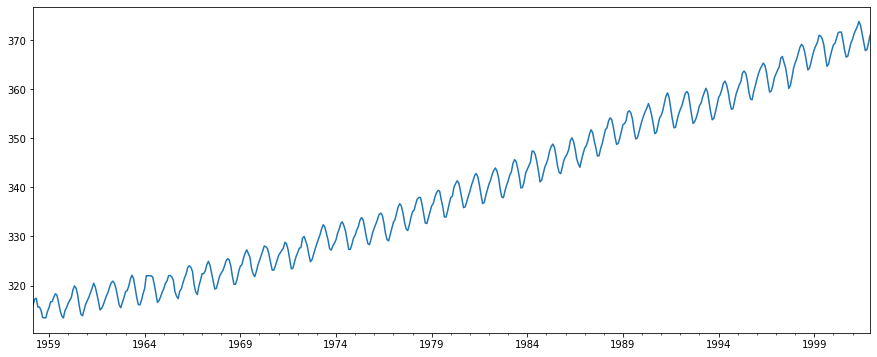

In [59]:
y.plot(figsize=(15, 6))
plt.show()

## 1. Is it Stationary?
Identifying whether a time series is stationary or non-stationary is very important. If it is stationary you can use ARMA models to predict the next values of the time series.

#### Augmented Dicky-Fuller
- The **null hypothesis** of the test is that the time series can be represented by a unit root, that it is **not stationary** (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

#### Taking the difference
try different techniques on taking the difference to make it stationary 
- `np.log(df)`*take the log*
- `np.sqrt(df)`*take the square root*
- `np.shift(1)/(df)` *Proportional change*

#### AR
AR(1) model: $y_t$ = $a_1y_{t-1}$ + $\epsilon_t$

#### MA
MA(1) model: $y_t$ = $m_1\epsilon_{t-1}$ + $\epsilon_t$

#### ARMA = AR + MA
ARMA(1,1) model: $a_1y_{t-1}$ + $m_1\epsilon_{t-1}$ + $\epsilon_t$

ARMA(p,q)
   - p is order of AR part
   - q is order of MA part
   
When fitting and working with AR, MA and ARMA models it is very important to understand the model order. You will need to pick the model order when fitting. Picking this correctly will give you a better fitting model which makes better predictions. 


## Decomposing the time series

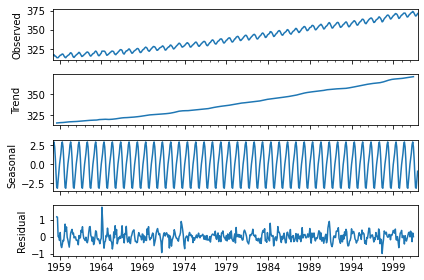

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(y)
decomp.plot()
plt.show()
# well the trend and season is very obvious

### Check for stationarity


In [61]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
# Print test statistic
print('test statistic is: ' + str(result[0]))

# Print p-value
print('p-value is ' + str(result[1]))

# Print critical values
print('Critical value is ' + str(result[4]))

# as expected, the time series wasn't stationary, so we will have to fix that via differencing

test statistic is: 2.3598099539953714
p-value is 0.9989901230798025
Critical value is {'1%': -3.4432119442564324, '5%': -2.8672126791646955, '10%': -2.569791324979607}


## 2. Manual inspection of acf and pacf

This is how a non stationary series would look like if you don't difference it..

In [0]:
# Examine the patterns of ACF and PACF (along with the time series plot and histogram)

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    #sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

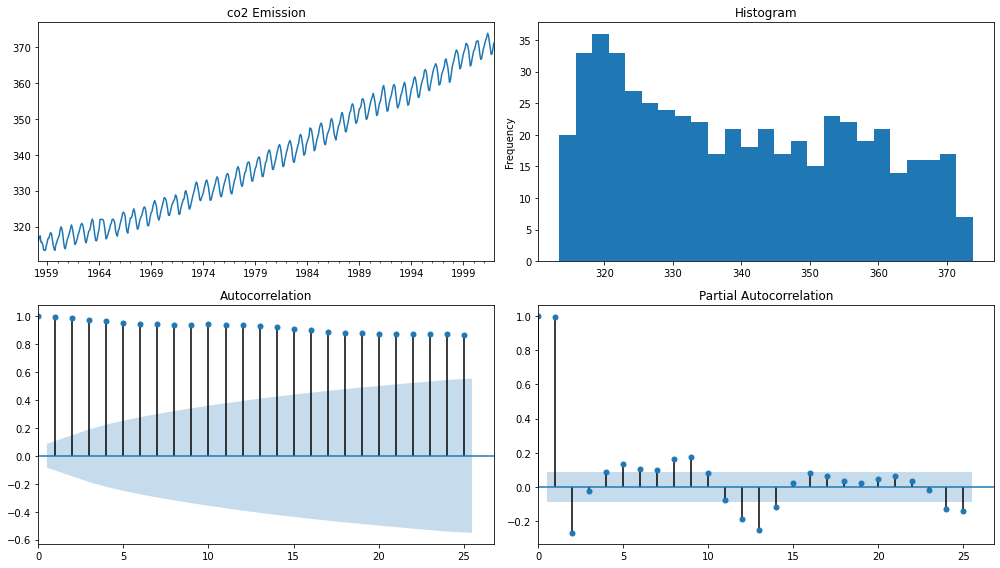

In [63]:
tsplot(y, title='co2 Emission', lags=25);

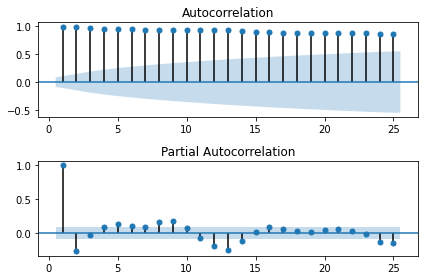

In [64]:
#############################################
## if you want to just look at acf and pcf ##
#############################################

# Create figure and subplots
fig, (ax1,ax2) = plt.subplots(2,1)

# Plot the ACF
plot_acf(y, lags=25, zero=False, ax=ax1)
plot_pacf(y, lags=25, zero=False, ax=ax2)
# Show figure
plt.tight_layout()
plt.show()

Lets try to make it stationary

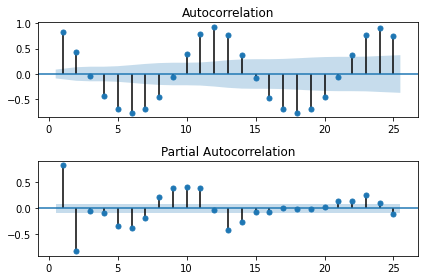

In [65]:
y_detrend = y - y.rolling(15).mean()
y_detrend = y_detrend.dropna()

# Create figure and subplots
fig, (ax1,ax2) = plt.subplots(2,1)

# Plot the ACF
plot_acf(y_detrend, lags=25, zero=False, ax=ax1)
plot_pacf(y_detrend, lags=25, zero=False, ax=ax2)
# Show figure
plt.tight_layout()
plt.show()
# beautiful time period of 12!

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe7ff079dd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe7fee87588>)

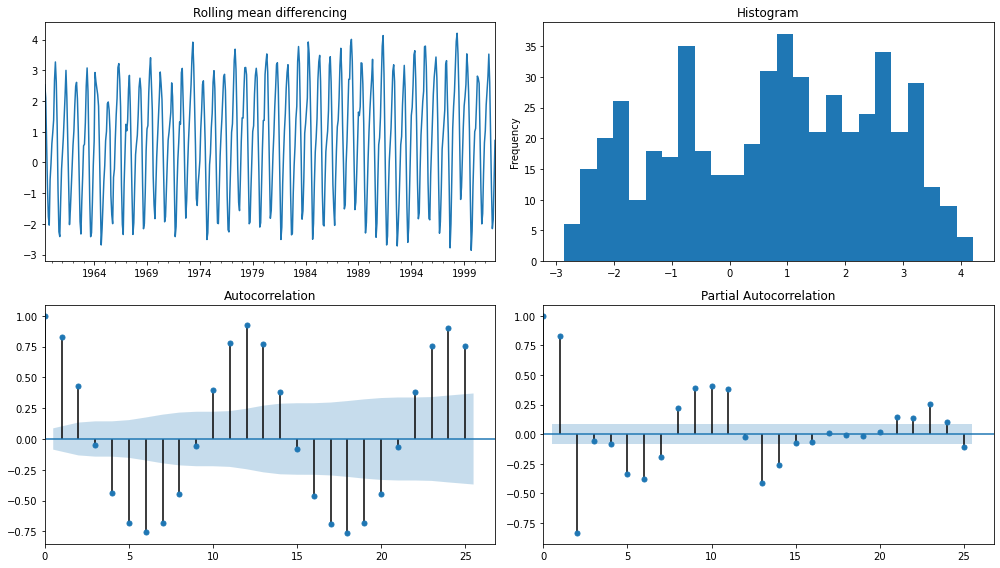

In [66]:
tsplot(y_detrend, title = 'Rolling mean differencing', lags = 25)

In [67]:
#Take the first order difference and the seasonal difference of the time series and drop the NaN values. 
#The seasonal period is 12 months.
y_diff = y.diff(1).diff(12).dropna()
result_diff = adfuller(y_diff)
print('test statistic is: ' + str(result_diff[0]))
print('p-value is ' + str(result_diff[1]))
print('Critical value is ' + str(result_diff[4]))

# looks like differencing once is good enough

test statistic is: -8.724891601521811
p-value is 3.308993777749871e-14
Critical value is {'1%': -3.4435761493506294, '5%': -2.867372960189225, '10%': -2.5698767442886696}


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe7fed81cf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe7ff171a58>)

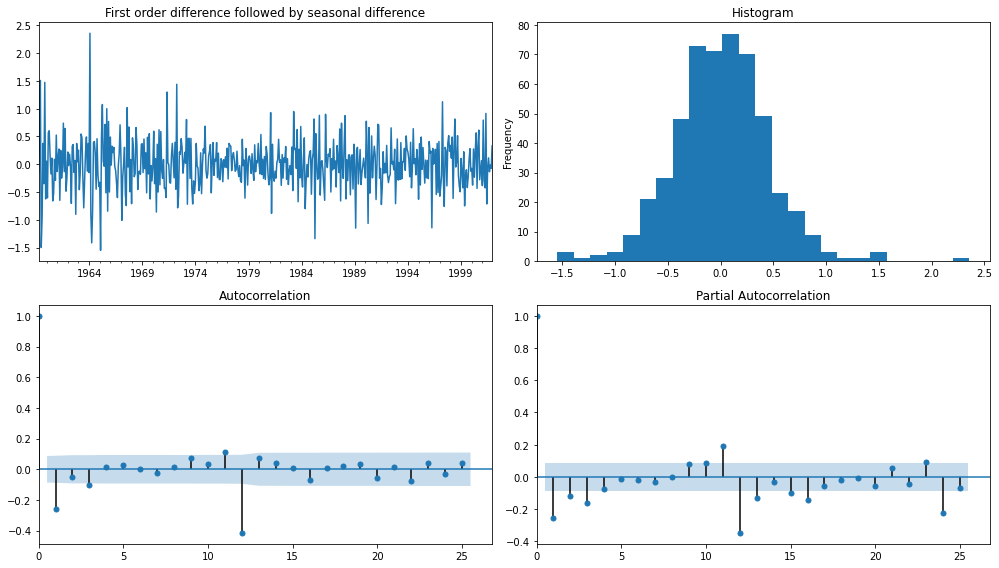

In [68]:
tsplot(y_diff, title = 'First order difference followed by seasonal difference', lags = 25)

Looks like seasonal diff hit the spot

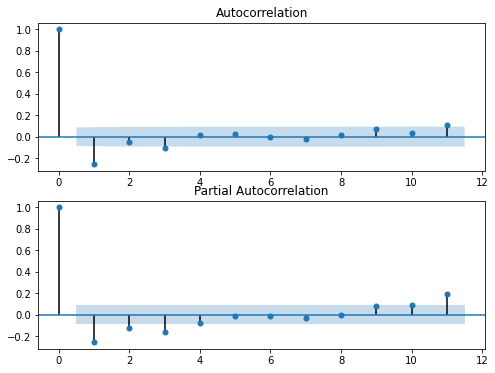

In [69]:
########################################################################
## Non Seasonal ACF and PACF using first order diff then seasonal diff##
########################################################################

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1 using seasonal diff
plot_acf(y_diff,lags=11, ax=ax1)

# Plot the PACF on ax2 using seasonal diff
plot_pacf(y_diff,lags=11, ax=ax2)

plt.show()

## Not quite sure if its AR, MA or ARMA just by looking at the graphs, could be ar1, ma1
## both acf and pacf looks like they just tail off

##### How to choose SARIMA order?
|      |AR(p)|MA(q)|ARMA(p,q)|   |
|---   |---  |---|---|---|
|ACF   |Tails off   |Cuts off after lag q   |Tails off   |   |
|PACF  |Cuts off after lag p|Tails off|Tails off|   |

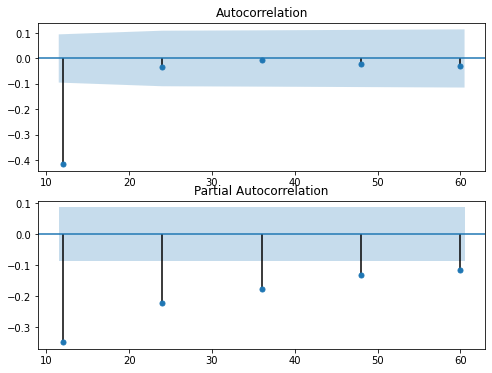

In [70]:
###########################
## Seasonal ACF and PACF ##
###########################

# Make list of lags to see get clues to seasonal AR & MA
lags = [12, 24, 36, 48, 60]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(y_diff, lags=lags,zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(y_diff, lags=lags,zero=False, ax=ax2)

plt.show()

# The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF
## The Seasonal ACF and PACF look like an MA(1) model seasonal

#### AIC & BIC
AIC - Akaike information criterion
- Lower AIC indicates a better model
- AIC likes to choose simple models with lower order

BIC - Bayesian information criterion
- Very similar to AIC
- Lower BIC indicates a better model
- BIC likes to choose simple models with lower order

Key Differences
- BIC favors simpler models than AIC
- AIC is better at choosing predictive models
- BIC is better at choosing good explanatory model

In [71]:
pip install pmdarima

## 3. Automated ARIMA via `pmdarima`

In [72]:
## Using an automated package
## temporary pause for now
import pmdarima as pm 
model1 = pm.auto_arima(y,
                      seasonal=True, 
                      m=12, #m is seasonal period
                      d=1, D=1, 
                      max_p=2, max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 
model1.summary()

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,1,1,12) [intercept=True]; AIC=343.805, BIC=377.728, Time=10.797 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=635.791, BIC=644.272, Time=0.117 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=493.084, BIC=510.045, Time=1.735 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=350.496, BIC=367.457, Time=3.418 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=633.800, BIC=638.040, Time=0.056 seconds
Fit ARIMA(2,1,2)x(0,1,1,12) [intercept=True]; AIC=341.926, BIC=371.608, Time=9.536 seconds
Fit ARIMA(2,1,2)x(0,1,0,12) [intercept=True]; AIC=587.697, BIC=613.139, Time=1.494 seconds
Fit ARIMA(2,1,2)x(0,1,2,12) [intercept=True]; AIC=343.726, BIC=377.648, Time=23.725 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Fit ARIMA(2,1,2)x(1,1,0,12) [intercept=True]; AIC=478.660, BIC=508.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -164.273
Date:                            Tue, 02 Jun 2020   AIC                            338.545
Time:                                    09:11:10   BIC                            359.747
Sample:                                         0   HQIC                           346.856
                                            - 526                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      1.637      0.102      -0.000       0.002
ar.L1          0.4229      0.083      5.072      0.000       0.259       0.586
ma.L1         -0.7252      0.067    -10.804      0.000      -0.857      -0.594
ma.S.L12      -0.8815      0.026    -34.104      0.000      -0.932      -0.831
sigma2         0.1072      0.005     21.458      0.000       0.097       0.117
===================================================================================
Ljung-Box (Q):                       42.17   Jarque-Bera (JB):               116.59
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
# auto arima said SARIMAX(1, 1, 1)x(0, 1, 1, 12)
mod = SARIMAX(y, 
            order = (1,1,1),
            seasonal_order=(0,1,1,12))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -165.748
Date:                            Tue, 02 Jun 2020   AIC                            339.497
Time:                                    09:11:12   BIC                            356.458
Sample:                                03-01-1958   HQIC                           346.145
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3974      0.085      4.652      0.000       0.230       0.565
ma.L1         -0.6994      0.069    -10.127      0.000      -0.835      -0.564
ma.S.L12      -0.8714      0.027    -32.058      0.000      -0.925      -0.818
sigma2         0.1080      0.005     21.763      0.000       0.098       0.118
===================================================================================
Ljung-Box (Q):                       39.80   Jarque-Bera (JB):               115.09
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

|Test   	|Null hypothesis   	|P-value name 	|   	|   	|
|---	|---	|---	|---	|---	|
|Ljung-Box   	|There are no correlations in the residual   	|Prob(Q)   	|   	|   	|
|Jarque-Bera   	|The residuals are normally distributed   	|Prob(JB)   	|   	|   	|


#### Plot diagnostics
|Test	|Good fit   	|   	|   	|   	|
|---	|---	|---	|---	|---	|
|Standardized residual   	|There are no obvious patterns in the residuals   	|   	|   	|   	|
|Histogram plus kde estimate   	|The KDE curve should be very similar to the normal distribution   	|   	|   	|   	|
|Normal Q-Q   	|Most of the data points should lie on the straight line   	|   	|   	|   	|
| Correlogram   |95% of correlations for lag greater than one should not be significant |   	|   	|   	|

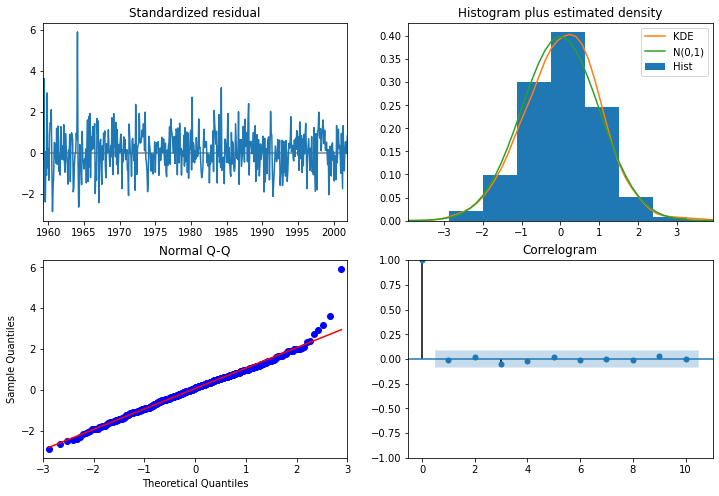

In [74]:
# the JB numbers are saying that my residuals are not normally distributed..
results.plot_diagnostics(figsize=(12,8))
plt.show()
# qq plot is not looking good either..

### Validating forecasts

In [75]:
y.tail()

2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, dtype: float64

## 4. **Dynamic forecasting**
a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

#### Non Dynamic forecast

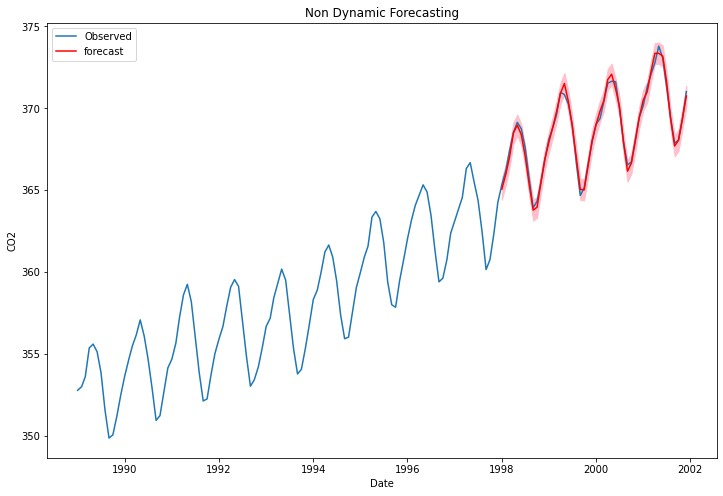

In [76]:
plt.figure(figsize=(12,8))
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
mean_forecast = pred.predicted_mean
pred_ci = pred.conf_int()

lower_limits = pred_ci.loc[:,'lower co2']
upper_limits = pred_ci.loc[:,'upper co2']

plt.plot(y['1989':].index, y['1989':], label='Observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')

plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Non Dynamic Forecasting')
plt.legend()
plt.show()

In [77]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.08


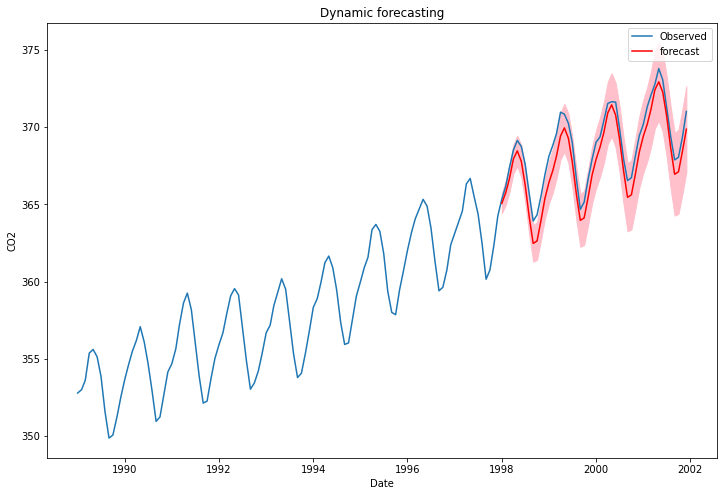

In [78]:
plt.figure(figsize=(12,8))
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True)
mean_forecast = pred.predicted_mean
pred_ci = pred.conf_int()

lower_limits = pred_ci.loc[:,'lower co2']
upper_limits = pred_ci.loc[:,'upper co2']

plt.plot(y['1989':].index, y['1989':], label='Observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')


plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Dynamic forecasting')
plt.legend()
plt.show()

In [79]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The MSE is a little worse off compared to non dynamic, which is to be expected given that we are relying on less historical data from the time series.

The Mean Squared Error of our forecasts is 1.11


In [80]:
# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*len(y))+1
n_forecast=len(y)-n_train
#ts_df
ts_train = y.iloc[:n_train]
ts_test = y.iloc[n_train:]
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(500,)
(26,)
Training Series: 
 1999-06-01    370.250
1999-07-01    369.000
1999-08-01    366.700
1999-09-01    364.675
1999-10-01    365.140
Freq: MS, Name: co2, dtype: float64 

Testing Series: 
 1999-11-01    366.650
1999-12-01    367.900
2000-01-01    369.020
2000-02-01    369.375
2000-03-01    370.400
Freq: MS, Name: co2, dtype: float64


## 5. **Self defined grid search for optimal parameters based on different criteria**

In [0]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    Adapted from Jeffrey Yau's 2016 pydata tutorial
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [0]:
def model_gridsearch(ts,p_min,d_min,q_min,p_max,d_max,q_max,sP_min,sD_min,sQ_min,sP_max,sD_max,sQ_max,trends,
                     s=None,enforce_stationarity=True,enforce_invertibility=True,simple_differencing=False,
                     verbose=False,filter_warnings=True,):
    '''Run grid search of SARIMAX models and save results.
    Adapted from Jeffrey Yau's 2016 pydata tutorial and modified
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic','het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1','insample_rmse','insample_mape',
            'outsample_rmse','outsample_mape','datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        """
        enforce stationarity: Whether or not to transform the AR parameters to enforce stationarity in the autoregressive component of the model. 
        Default is True.
        
        enforce invertibility: Whether or not to transform the MA parameters to enforce invertibility in the moving average component of the model. 
        Default is True.

        """
        try:
            model = SARIMAX(ts,
                            trend=trend,
                            order=(p, d, q),
                            seasonal_order=(sP, sD, sQ, s),
                            enforce_stationarity=enforce_stationarity,
                            enforce_invertibility=enforce_invertibility,
                            simple_differencing=simple_differencing,
                                  )

            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            ###########################################
            pred_begin = ts_train.index[sarima_fit.loglikelihood_burn]
            pred_end = ts_test.index[-1]
            
            pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                                end=pred_end.strftime('%Y-%m-%d'))
            # getting predicted results
            pred_mean = pred.predicted_mean

            ### train test results ###
            insample_rmse = get_rmse(ts_train, pred_mean[ts_train.index])
            insample_mape = get_mape(ts_train, pred_mean[ts_train.index])
            #insample_mase = get_mase(ts_train, pred_mean[ts_train.index])

            outsample_rmse = get_rmse(ts_test, pred_mean[ts_test.index])
            outsample_mape = get_mape(ts_test, pred_mean[ts_test.index])
            #outsample_mase = get_mase(ts_test, pred_mean[ts_test.index])

            if verbose:
                print(model_results.summary())

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing
            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic

            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']
            this_model.loc[mod_num, 'insample_rmse'] = insample_rmse
            this_model.loc[mod_num, 'insample_mape'] = insample_mape
            this_model.loc[mod_num, 'outsample_rmse'] = outsample_rmse
            this_model.loc[mod_num, 'outsample_mape'] = outsample_mape
            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')
            df_results = df_results.append(this_model)
            
            mod_num+=1
            print(str(mod_num) + ' fitted..')
        except:
            continue
    return df_results

In [90]:
# run model grid search
p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 1
q_max = 2

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 2
sD_max = 1
sQ_max = 2

# trends=['n', 'c']
trends=['n']

df_results = model_gridsearch(ts_train,p_min,d_min,q_min,p_max,d_max,q_max,sP_min,
                              sD_min,sQ_min,sP_max,sD_max,sQ_max,trends,
                              s=12, enforce_stationarity=True,
                              enforce_invertibility=True,
                              verbose=False)

1 fitted..
2 fitted..
3 fitted..
4 fitted..
5 fitted..
6 fitted..
7 fitted..
8 fitted..
9 fitted..
10 fitted..
11 fitted..
12 fitted..
13 fitted..
14 fitted..
15 fitted..
16 fitted..
17 fitted..
18 fitted..
19 fitted..
20 fitted..
21 fitted..
22 fitted..
23 fitted..
24 fitted..
25 fitted..
26 fitted..
27 fitted..
28 fitted..
29 fitted..
30 fitted..
31 fitted..
32 fitted..
33 fitted..
34 fitted..
35 fitted..
36 fitted..
37 fitted..
38 fitted..
39 fitted..
40 fitted..
41 fitted..
42 fitted..
43 fitted..
44 fitted..
45 fitted..
46 fitted..
47 fitted..
48 fitted..
49 fitted..
50 fitted..
51 fitted..
52 fitted..
53 fitted..
54 fitted..
55 fitted..
56 fitted..
57 fitted..
58 fitted..
59 fitted..
60 fitted..
61 fitted..
62 fitted..
63 fitted..
64 fitted..
65 fitted..
66 fitted..
67 fitted..
68 fitted..
69 fitted..
70 fitted..
71 fitted..
72 fitted..
73 fitted..
74 fitted..
75 fitted..
76 fitted..
77 fitted..
78 fitted..
79 fitted..
80 fitted..
81 fitted..
82 fitted..
83 fitted..
84 fitted..
8

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


194 fitted..
195 fitted..
196 fitted..
197 fitted..
198 fitted..
199 fitted..
200 fitted..
201 fitted..
202 fitted..
203 fitted..
204 fitted..
205 fitted..
206 fitted..
207 fitted..
208 fitted..
209 fitted..
210 fitted..
211 fitted..
212 fitted..
213 fitted..
214 fitted..
215 fitted..
216 fitted..
217 fitted..
218 fitted..
219 fitted..
220 fitted..
221 fitted..
222 fitted..
223 fitted..
224 fitted..
225 fitted..
226 fitted..
227 fitted..
228 fitted..
229 fitted..
230 fitted..
231 fitted..
232 fitted..
233 fitted..
234 fitted..
235 fitted..
236 fitted..
237 fitted..
238 fitted..
239 fitted..
240 fitted..
241 fitted..
242 fitted..
243 fitted..
244 fitted..
245 fitted..
246 fitted..
247 fitted..
248 fitted..
249 fitted..
250 fitted..
251 fitted..
252 fitted..
253 fitted..
254 fitted..
255 fitted..
256 fitted..
257 fitted..
258 fitted..
259 fitted..
260 fitted..
261 fitted..
262 fitted..
263 fitted..
264 fitted..
265 fitted..
266 fitted..
267 fitted..
268 fitted..
269 fitted..
270 fitted..

In [91]:
df_results.sort_values(by='aic').head(10)

,p,d,q,sP,sD,sQ,s,trend,enforce_stationarity,enforce_invertibility,simple_differencing,aic,bic,het_p,norm_p,sercor_p,dw_stat,arroots_gt_1,maroots_gt_1,insample_rmse,insample_mape,outsample_rmse,outsample_mape,datetime_run
174,1,1,1,2,1,2,12,n,True,True,False,328.854,358.172,0.000736517,2.79945e-26,0.732809,1.99545,True,True,0.344143,0.0779763,0.466128,0.100158,2020-06-02 09:30:00
192,1,1,2,2,1,2,12,n,True,True,False,330.146,363.652,0.000571395,8.79226e-25,0.631039,1.99871,True,True,0.344143,0.0781128,0.394562,0.0811112,2020-06-02 09:31:51
278,2,1,1,2,1,2,12,n,True,True,False,330.152,363.658,0.000596142,1.01383e-24,0.633756,1.99511,True,True,0.344152,0.0780959,0.400314,0.0826888,2020-06-02 09:43:16
296,2,1,2,2,1,2,12,n,True,True,False,331.418,369.112,0.000593839,3.10824e-25,0.691589,2.00715,True,True,0.343886,0.0779177,0.446867,0.0947264,2020-06-02 09:45:45
84,0,1,2,2,1,2,12,n,True,True,False,331.624,360.942,0.000212508,2.77428e-27,0.345506,1.96809,True,True,0.345465,0.078337,0.363309,0.0744407,2020-06-02 09:20:50
161,1,1,1,0,1,1,12,n,True,True,False,332.419,349.172,0.000418583,2.53442e-25,0.584405,2.00145,True,True,0.346901,0.0786428,0.402912,0.0872269,2020-06-02 09:28:40
162,1,1,1,0,1,2,12,n,True,True,False,334.323,355.264,0.000380017,6.8879e-26,0.620382,2.00158,True,True,0.346726,0.0786601,0.388979,0.0832981,2020-06-02 09:28:47
167,1,1,1,1,1,1,12,n,True,True,False,334.334,355.275,0.000384141,8.0168e-26,0.616491,2.0016,True,True,0.346747,0.078658,0.390749,0.083761,2020-06-02 09:29:07
266,2,1,1,0,1,1,12,n,True,True,False,334.4,355.341,0.000413461,2.91133e-25,0.590664,1.99669,True,True,0.346924,0.078625,0.404891,0.0877788,2020-06-02 09:41:30
179,1,1,2,0,1,1,12,n,True,True,False,334.406,355.347,0.000414873,2.79105e-25,0.588821,1.99827,True,True,0.346917,0.078631,0.404298,0.087613,2020-06-02 09:30:07


In [92]:
#pick whichever parameter that suits your objective
mod = SARIMAX(ts_train, order=(1,1,1), seasonal_order=(0,1,1,12))
sarima_fit = mod.fit()
print(sarima_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                co2   No. Observations:                  500
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -162.209
Date:                            Tue, 02 Jun 2020   AIC                            332.419
Time:                                    09:46:08   BIC                            349.172
Sample:                                03-01-1958   HQIC                           339.000
                                     - 10-01-1999                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4066      0.088      4.600      0.000       0.233       0.580
ma.L1         -0.7028      0.072   

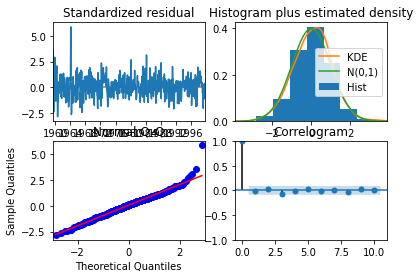

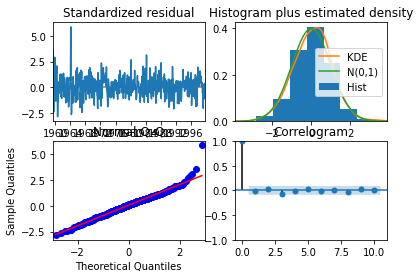

In [93]:
sarima_fit.plot_diagnostics()

2001-12-01 00:00:00


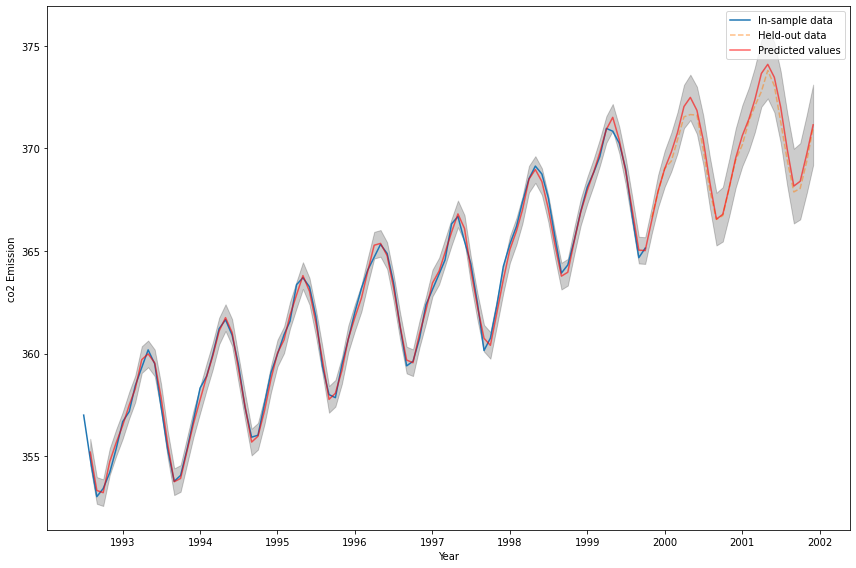

In [94]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train.iloc[412:], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--', alpha = 0.5)

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit.loglikelihood_burn]
pred_end = ts_test.index[-1]
print(pred_end)
pred = sarima_fit.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))

pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)
lower_limits = pred_ci.loc[:,'lower co2']
upper_limits = pred_ci.loc[:,'upper co2']


ax1.plot(pred_mean.iloc[400:], 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.iloc[400:].index,
                 lower_limits.iloc[400:],
                 upper_limits.iloc[400:], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("co2 Emission")
ax1.legend(loc='best');
fig.tight_layout();

#### Insample results

In [95]:
rmse = get_rmse(ts_train, pred_mean[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean[ts_train.index])
print("MASE: ", mase)

RMSE:  0.34690110726742496
MAPE:  0.07864276249751843
MASE:  nan


Out of sample evaluation

In [96]:
rmse = get_rmse(ts_test, pred_mean[ts_test.index])
print(rmse)

mape = get_mape(ts_test, pred_mean[ts_test.index])
print(mape)

mase = get_mase(ts_test, pred_mean[ts_test.index])
print(mase)

0.402912107565536
0.08722687965284184
0.9793880841372375


## 6. **The Box-Jenkins method**
- Identification
    - Is the time series stationary?
        - `adfuller()` augmented Dicky-Fuller
    - What differencing will make it stationary?
    - What transforms will make it stationary?
        - df.diff(), np.log(), np.sqrt()
    - What values of p and q are most promising?
- estimation
    - choose between models using AIC and BIC
        - `results.aic`,`results.bic`
- model diagnostics
    - are residuals uncorrelated
    - are residuals normally distributed
        - `results.plot_diagnostics()`
        - `results.summary'
- ready to make forecasts
    - `results.get_forecast()`

#### **Box-Jenkins with seasonal data**
- Determine if time series is seasonal
- find seasonal period
- find transforms to make data stationary
    - seasonal and non-seasonal differencing
    - other transforms
    
#### Mixed differencing
- `D` should be 0 or 1
- `d + D` should be 0-2


**additive seasonality**
- additive series = trend + season
- proceed as usual with differencing

**multiplicative seasonality**
- multiplicative series = trend x season
- apply log transform first - `np.log`


[Other source](https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)<br>

[Anomaly Detection](https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Anomaly%20Detection.ipynb)